In [1]:
import os
#import ipdb

import pandas as pd
import matplotlib as mpl
from matplotlib import lines
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

EXP_NAME = "logs"

MAX_ROUNDS = 70
MAX_YVAL = 5

RESULTS_DIR = os.path.join( os.getcwd(),'results')

headers = ['time', 'elapsed', 'remotehost', 'code/status','bytes','method','URL','rfc931', 'peerstatus/peerhost','type'] 
headers = ['time', 'elapsed', 'bytes']
dtypes = [pd.datetime, float, float]

##SET SEABORN STYLE
sns.set_style("whitegrid")
sns.set_context("paper")

##SET MATPLOTLIB STYLE
TICKS_FONTSIZE = 16
LABEL_FONTSIZE=18
LEGEND_FONTSIZE=15
linestyles = (':','-','.','--')

mpl.rcParams['xtick.labelsize'] = TICKS_FONTSIZE 
mpl.rcParams['ytick.labelsize'] = TICKS_FONTSIZE
mpl.rcParams['legend.fontsize'] = TICKS_FONTSIZE
mpl.rcParams['axes.labelsize'] = LABEL_FONTSIZE
mpl.rcParams['axes.titlesize'] = LABEL_FONTSIZE
mpl.rcParams['font.size'] = LABEL_FONTSIZE
plt.rc('legend',**{'fontsize':LEGEND_FONTSIZE})


#Read input files from the directory and returns DataTable object in a combined list
def read_inputs(flag):
    #Get list of nodes(files) with results
    INPUT_DIR = os.path.join( os.getcwd(), EXP_NAME)
    dirs = [f for f in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, f))]
    #Load results from each node
    nodes_results = {}
    for sub_dir in dirs:
        nodes = [f for f in os.listdir(INPUT_DIR+'/'+sub_dir) if os.path.isfile(os.path.join(INPUT_DIR+'/'+sub_dir, f))]
        for node in nodes:
            file =''
            #if flag == 0 & node.endswith('0.log'):
            #    file == os.path.join(INPUT_DIR+'/'+sub_dir,node)
            #elif flag == 1 & node.endswith('1.log'):
            #    file = os.path.join(INPUT_DIR+'/'+sub_dir,node)
            #elif flag == 2:
            file = os.path.join(INPUT_DIR+'/'+sub_dir,node)
            #print('reading:', file)
            #else:
            #    continue
            try:
                temp = pd.read_csv(file, sep=' ', header=None, usecols=[0,1,4])
                temp.columns = headers
                temp['time'] = pd.to_datetime(temp['time'], unit='s')
                temp.set_index('time')
                if sub_dir in nodes_results:
                    nodes_results[sub_dir] = pd.concat([nodes_results[sub_dir], temp])
                else:
                    nodes_results[sub_dir] = temp                    
            except Exception:
                print(node, 'EXception')
    return nodes_results


    
nodes_all = read_inputs(2)
    #nodes_even = read_inputs(0)
    #nodes_odd = read_inputs(1)
    #plot_bytes_per_day(nodes_all,'bytes')
    #plot_request_numbers(nodes_all,'bytes')
    #plot_hourly_request_number(nodes_all,'bytes')
    #plot_bytes_per_second(nodes_all,'bytes')
    
    

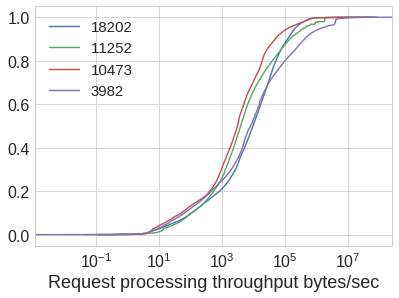

In [2]:
def plot_bytes_per_day(results, var):
    
    
    #labels = []
    #for key in results:
    df = results['3982']
    df = df.set_index(df.time)        
    df_sample = df.resample('240Min').sum()        
    df_sample[(var)].plot(logy=True)        
    #labels.append(key)
    #plt.legend(labels)
    plt.xlabel('Days')
    plt.ylabel('Bytes')
    plt.show()
    

def plot_request_numbers(results, var):
    labels =[]
    for key in results:
        df = results[key]
        df = df.set_index(df.time)        
        ecdf = getECDF(df,'bytes')
        labels.append(key)
        ecdf.plot()
    plt.legend(labels)
    plt.xlim(0, 10000)
    plt.xlabel('Request size (bytes)')
    plt.show()
    
def plot_hourly_request_size(results,var):  
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(pd.DatetimeIndex(df.time))
        df_sample = df.resample('60Min').mean()
        ecdf = getECDF(df_sample, var)
        ax = ecdf.plot(logx=True)
        labels.append(key)
    plt.legend(labels)
    plt.xlabel('Hourly request size (bytes)')
    plt.show()
    
def plot_hourly_request_number(results, var):
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(pd.DatetimeIndex(df.time))
        df_sample = df.resample('60Min').count()
        ecdf = getECDF(df_sample, var)
        labels.append(key)
        ecdf.plot()
    plt.legend(labels)
    #plt.xlim(0,10000)
    plt.xlabel('Number of hourly request')
    plt.show()
    
def plot_bytes_per_second(results,var):
    labels = []
    for key in results:
        df = results[key]
        df = df.set_index(pd.DatetimeIndex(df.time))
        df = df[(df['elapsed']>0) & df['bytes']>0 ]
        df['bytes_second'] = df['bytes']/df['elapsed']
        df['bytes_second'] = df['bytes_second']*1000
        #df[('bytes_second')].plot()
        labels.append(key)
        ecdf = getECDF(df, 'bytes_second')
        ecdf.plot(logx=True)
    plt.legend(labels)
    plt.xlabel('Request processing throughput bytes/sec')
    plt.show()

def getECDF(df, var):
    """Helper function that caclulates the ECDF of a dataframe"""
    df = df[var].value_counts()
    ecdf = df.sort_index().cumsum()*1./df.sum()
    return ecdf
    
#plot_bytes_per_day(nodes_all,'bytes')
#plot_request_numbers(nodes_all,'bytes')
#plot_hourly_request_number(nodes_all,'bytes')
#plot_hourly_request_size(nodes_all,'bytes')
plot_bytes_per_second(nodes_all,'bytes')

In [ ]:
def plot_percentile(results):
    for key in results:
        df = results[key]
        df = 